# Optimization

## Pregenerated site with wake effects from neighbouring wind farms

In some cases, calculation of wake interaction between the wind farm to optimize and neighbouring wind farms considerably slow down an optimization work flow. To avoid this, a site, which includes wake effects from neighbouring wind farms, can be pregenerated and used for the optimization.

The speed up of this solution depends on the number of turbines in the current and the neighbouring wind farms as well as the type of sites. If the original site is a uniform site, then a pregenerated site with wake effects from neighbouring wind farms may slow down the workflow as it adds interpolation of inflow characteristics in space.

Note also, that a pregenerated site with wake effects from neighbouring wind farms is only eqivalent to the full simulation  if the applied deficit model uses the effective wind speed (some models have an option to switch between effective and free-stream local wind speed). 

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

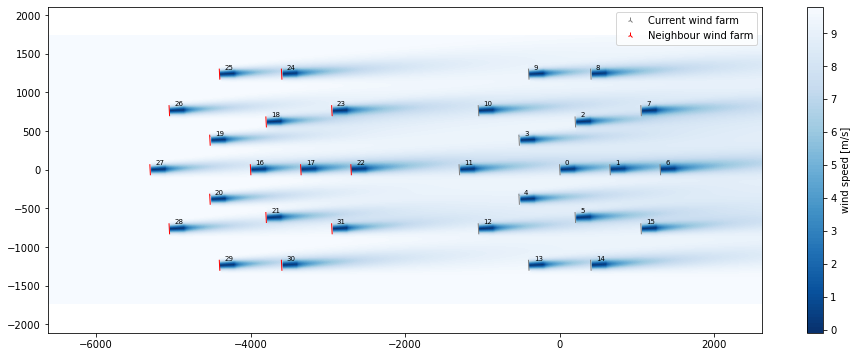

In [2]:
# import and setup site and windTurbines
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.wind_turbines import WindTurbines
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.superposition_models import LinearSum

site = IEA37Site(16)

# setup current, neighbour and all positions
wt_x, wt_y = site.initial_position.T
neighbour_x, neighbour_y = wt_x-4000, wt_y
all_x, all_y = np.r_[wt_x,neighbour_x], np.r_[wt_y,neighbour_y]


windTurbines = WindTurbines.from_WindTurbines([IEA37_WindTurbines(),IEA37_WindTurbines()])
windTurbines._names = ["Current wind farm","Neighbour wind farm"]
types = [0]*len(wt_x) + [1]*len(neighbour_x)

wf_model = PropagateDownwind(site, windTurbines,
                                 wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                                 superpositionModel=LinearSum())
# Consider wd=270 +/- 60 deg only
wd_lst = np.arange(210,331)

plt.figure(figsize=(16, 6))
wf_model(all_x, all_y, type=types, wd=267, ws=9.8, h=110).flow_map().plot_wake_map()

Run simulation of all wind turbines and calculate AEP of current wind farm

In [3]:
%%timeit -n 1 -r 1
print(wf_model(all_x, all_y, type=types, ws=9.8, wd=wd_lst).aep().isel(wt=np.arange(len(wt_x))).sum())

<xarray.DataArray 'AEP [GWh]' ()>
array(119.41784112)
108 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Make a flox_box covering the area of interest (i.e. the current wind farm + 100m)

In [4]:
ext = 1000
flow_box = wf_model(neighbour_x, neighbour_y, wd=wd_lst).flow_box(
    x=np.linspace(min(wt_x) - ext, max(wt_x) + ext, 101),
    y=np.linspace(min(wt_y) - ext, max(wt_y) + ext, 101),
    h=110)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:05<00:00, 22.66it/s]


Create a new site based on the flow box

In [5]:
from py_wake.site.xrsite import XRSite
wake_site = XRSite.from_flow_box(flow_box)

Plot the "free-stream" inflow wind speed of the current wind farm

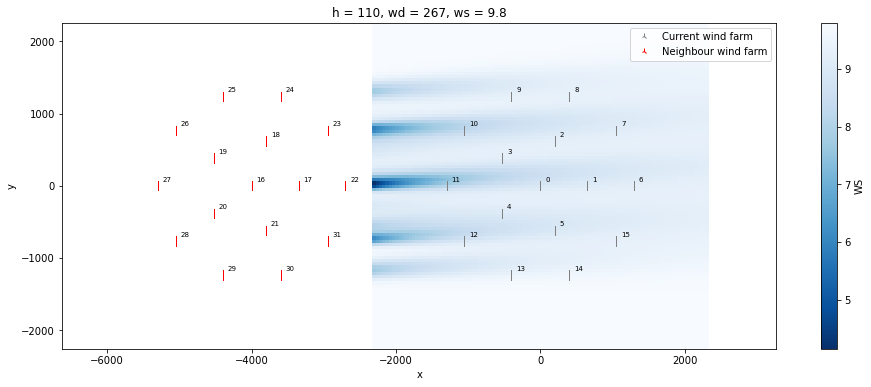

In [6]:
plt.figure(figsize=(16, 6))
wake_site.ds.WS.sel(wd=267).plot(cmap = 'Blues_r')
windTurbines.plot(all_x, all_y, types, wd=270)

Setup new wind farm model with the new pregenerated site

In [7]:
wf_model_wake_site = PropagateDownwind(wake_site, windTurbines,
                                           wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                                           superpositionModel=LinearSum())

In [8]:
%%timeit -n 1 -r 1
print(wf_model_wake_site(wt_x, wt_y, ws=9.8, wd=wd_lst).aep().sum())

<xarray.DataArray 'AEP [GWh]' ()>
array(119.41418086)
53.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The AEP is not exactly equal due to interpolation errors. The discrepancy can be lowered by increasing the resolution of the flow box.

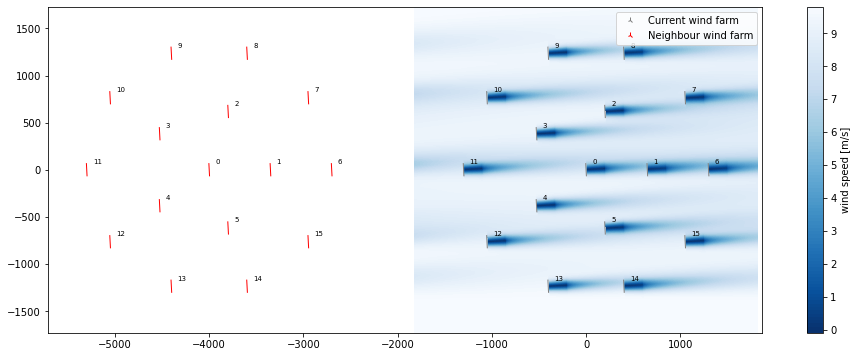

In [9]:
plt.figure(figsize=(16, 6))
wf_model_wake_site(wt_x, wt_y, wd=267, ws=9.8, h=110).flow_map().plot_wake_map()
windTurbines.plot(neighbour_x, neighbour_y, types=1, wd=267)